In [16]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['OMP_NUM_THREADS'] = '3'
os.environ['KMP_BLOCKTIME'] = '1'
import numpy as np
import gc
from tqdm.auto import tqdm
from dataset import get_labelled, get_unlabelled, _preload, _unload, unlabelled_generator, rendred_unlabelled_generator
from render_lookups import render_lookups, render_examples, get_rendered_examples
from Commit import CommitFactory
from Model import CommitDiffModelFactory
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import ticker


In [2]:
 print(tf.__version__)

2.11.0


In [3]:
##### META PARAMS #####

# If these two change, the data must be re-rendered!
##########################################

#Size / depth / length of each individual context/path
CONTEXT_SIZE = 8
#CONTEXT_SIZE = 16

#Total number of contexts to sample per bag
BAG_SIZE = 128

#BAG_SIZE = 256

##########################################

#Encoder to use
ENCODER = 0

#Size of fixed length vector to encode to
OUTPUT_SIZE = 512

# Hard limit to filter bags by. Bags which exceed this size won't even be sampled.
# Set to None to turn off
MAX_BAG_SIZE_FILTER = 2048 * 2

#Maximum number of labelled commits to train on
MAX_LABELLED_COMMITS = 11776

#Maximum number of unlabelled commits to train on
MAX_UNLABELLED_COMMITS = 4096 * 8 * 8

#Batch size for unsupervised training. Higher = faster but more memory required and may(?) reduce quality. Jury's out
SIAM_BATCH_SIZE = 2048
SIAM_BATCHES_PER_UPDATE = 2

SUPERVISED_BATCH_SIZE = 128

UNSUPERVISED_EPOCHS = 512
SUPERVISED_EPOCHS = 1024

NUM_INITIAL_SEARCHES = None  #Set to None to skip the search!
NUM_EPOCHS_PER_SEARCH = 2

In [4]:
Commit = CommitFactory(BAG_SIZE=BAG_SIZE, CONTEXT_SIZE=CONTEXT_SIZE)

In [5]:
#You can download these data folders from drive! Unless you want to change the settings.
#They go in the data/commit_lookups/

# Only run if you need to re-process the raw pickles !!!
# render_lookups(BAG_SIZE=BAG_SIZE, CONTEXT_SIZE=CONTEXT_SIZE)

In [6]:
# Only run if you need to re-process the raw pickles !!!
#render_examples(BAG_SIZE=BAG_SIZE, CONTEXT_SIZE=CONTEXT_SIZE)

In [7]:
output_types = (tf.float32, tf.float32)
output_shapes = ((BAG_SIZE, CONTEXT_SIZE), (BAG_SIZE, CONTEXT_SIZE))

dataset = tf.data.Dataset.from_generator(
    rendred_unlabelled_generator,
    output_types=output_types,
    output_shapes=output_shapes,
    args=(BAG_SIZE, CONTEXT_SIZE, MAX_UNLABELLED_COMMITS, MAX_BAG_SIZE_FILTER)
)

dataset = dataset.cache('unsupervised_cache').batch(SIAM_BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
CommitDiffModel = CommitDiffModelFactory(BAG_SIZE=BAG_SIZE, CONTEXT_SIZE=CONTEXT_SIZE, OUTPUT_SIZE=OUTPUT_SIZE)

In [9]:
model = CommitDiffModel(
    supervised_data_size = MAX_LABELLED_COMMITS,
    supervised_batch_size = SUPERVISED_BATCH_SIZE,
    unsupervised_data_size = MAX_UNLABELLED_COMMITS,
    unsupervised_epochs = UNSUPERVISED_EPOCHS,
    supervised_epochs = SUPERVISED_EPOCHS,
    siam_batch_size = SIAM_BATCH_SIZE,
    steps_per_update = SIAM_BATCHES_PER_UPDATE
)
model.initialize(encoder=0)

In [10]:
#If a model fails, we can restart it with this! Note: This won't restart the learning_rate schedule, but will help with the history and weights
cached_history = model.reload_saved_siam_model("sim_FINAL.pkl", dataset)
# Remember to lower the epochs accordingly. Also set NUM_INITIAL_SEARCHES to None!

#NOTE: You should back up your checkpoints folder!!!!!!
#Since the next run will now overwrite the old files

#This cached_history will need to be added to the graphs at the bottom.


Loaded saved file
Running single fit() epoch to intialize model weights
1/1 [==============================] - 1s 1s/step - loss: -0.0243 - lr: 0.3000
Resetting States
Updating Weights


In [11]:
#unsupervised_data = model.fit_siam_generator(dataset, epochs=UNSUPERVISED_EPOCHS, verbose=1, num_runs=NUM_INITIAL_SEARCHES, run_epochs=NUM_EPOCHS_PER_SEARCH)

In [12]:
#_preload(max_commits = MAX_LABELLED_COMMITS)

In [18]:
#X_train, X_test, y_train, y_test = get_labelled(BAG_SIZE=BAG_SIZE, CONTEXT_SIZE=CONTEXT_SIZE)
X_train, X_test, y_train, y_test = get_rendered_examples(balance=True) #You can also set balance=True (!)

X_train_1 = [X_train[i] for i in range(len(X_train)) if y_train[i] == 1]
y_train_1 = [y_train[i] for i in range(len(X_train)) if y_train[i] == 1]
X_train_0 = [X_train[i] for i in range(len(X_train)) if y_train[i] == 0]
y_train_0 = [y_train[i] for i in range(len(X_train)) if y_train[i] == 0]

X_test_1 = [X_test[i] for i in range(len(X_test)) if y_test[i] == 1]
y_test_1 = [y_test[i] for i in range(len(X_test)) if y_test[i] == 1]
X_test_0 = [X_test[i] for i in range(len(X_test)) if y_test[i] == 0]
y_test_0 = [y_test[i] for i in range(len(X_test)) if y_test[i] == 0]

len 4
len 4
len 4
len 4
len 4
len 4
len 2
len 2
len 4
len 4
len 4
len 4
len 4
len 4
len 4
len 4


In [19]:
print("Train set size", len(y_train))
print("Train set split", np.sum(y_train)/len(y_train))
print("Test set size", len(y_test))
print("Test set split", np.sum(y_test)/len(y_test))

Train set size 48224
Train set split 0.5
Test set size 12078
Test set split 0.5


In [20]:
#For memory optimization
#_unload()

In [21]:
supervised_results = model.fit_binary_classification(X_train, np.array(y_train), epochs=SUPERVISED_EPOCHS, batch_size=SUPERVISED_BATCH_SIZE, verbose=1, validation_data=[("test data",X_test, np.array(y_test)), ("Positive Test", X_test_1, np.array(y_test_1)), ("Negative Test", X_test_0, np.array(y_test_0)), ("Positive Train", X_train_1, np.array(y_train_1)), ("Negative Train", X_train_0, np.array(y_train_0))], save_checkpoints=True)

Epoch 1/1024
377/377 [==============================] - 19s 49ms/step - loss: 0.7427 - accuracy: 0.5012 - f1_score: 0.0762 - precision: 0.5024 - recall: 0.2481 - test data_loss: 0.6930 - test data_accuracy: 0.5000 - test data_f1_score: 0.3097 - test data_precision: 0.5000 - test data_recall: 1.0000 - Positive Test_loss: 0.6833 - Positive Test_accuracy: 1.0000 - Positive Test_f1_score: 0.4611 - Positive Test_precision: 1.0000 - Positive Test_recall: 1.0000 - Negative Test_loss: 0.7027 - Negative Test_accuracy: 0.0000e+00 - Negative Test_f1_score: 0.4874 - Negative Test_precision: 0.0000e+00 - Negative Test_recall: 0.0000e+00 - Positive Train_loss: 0.6833 - Positive Train_accuracy: 1.0000 - Positive Train_f1_score: 0.5871 - Positive Train_precision: 1.0000 - Positive Train_recall: 1.0000 - Negative Train_loss: 0.7027 - Negative Train_accuracy: 0.0000e+00 - Negative Train_f1_score: 0.6152 - Negative Train_precision: 0.0000e+00 - Negative Train_recall: 0.0000e+00
Epoch 2/1024
377/377 [====

Epoch 10/1024
377/377 [==============================] - 20s 50ms/step - loss: 0.5353 - accuracy: 0.6934 - f1_score: 0.6677 - precision: 0.6409 - recall: 0.8798 - test data_loss: 0.5291 - test data_accuracy: 0.7022 - test data_f1_score: 0.6688 - test data_precision: 0.6271 - test data_recall: 0.9974 - Positive Test_loss: 0.4260 - Positive Test_accuracy: 0.9974 - Positive Test_f1_score: 0.6721 - Positive Test_precision: 1.0000 - Positive Test_recall: 0.9974 - Negative Test_loss: 0.6322 - Negative Test_accuracy: 0.4070 - Negative Test_f1_score: 0.6727 - Negative Test_precision: 0.0000e+00 - Negative Test_recall: 0.0000e+00 - Positive Train_loss: 0.4199 - Positive Train_accuracy: 0.9990 - Positive Train_f1_score: 0.6776 - Positive Train_precision: 1.0000 - Positive Train_recall: 0.9990 - Negative Train_loss: 0.6396 - Negative Train_accuracy: 0.4004 - Negative Train_f1_score: 0.6798 - Negative Train_precision: 0.0000e+00 - Negative Train_recall: 0.0000e+00
Epoch 11/1024
377/377 [==========

Epoch 19/1024
377/377 [==============================] - 20s 50ms/step - loss: 0.5179 - accuracy: 0.7013 - f1_score: 0.7173 - precision: 0.6402 - recall: 0.9189 - test data_loss: 0.5149 - test data_accuracy: 0.7035 - test data_f1_score: 0.7174 - test data_precision: 0.6283 - test data_recall: 0.9969 - Positive Test_loss: 0.4427 - Positive Test_accuracy: 0.9970 - Positive Test_f1_score: 0.7187 - Positive Test_precision: 1.0000 - Positive Test_recall: 0.9970 - Negative Test_loss: 0.5871 - Negative Test_accuracy: 0.4105 - Negative Test_f1_score: 0.7188 - Negative Test_precision: 0.0000e+00 - Negative Test_recall: 0.0000e+00 - Positive Train_loss: 0.4334 - Positive Train_accuracy: 0.9979 - Positive Train_f1_score: 0.7208 - Positive Train_precision: 1.0000 - Positive Train_recall: 0.9979 - Negative Train_loss: 0.5952 - Negative Train_accuracy: 0.4012 - Negative Train_f1_score: 0.7214 - Negative Train_precision: 0.0000e+00 - Negative Train_recall: 0.0000e+00
Epoch 20/1024
377/377 [==========

Epoch 28/1024
377/377 [==============================] - 19s 50ms/step - loss: 0.5141 - accuracy: 0.7054 - f1_score: 0.7334 - precision: 0.6429 - recall: 0.9241 - test data_loss: 0.5258 - test data_accuracy: 0.7035 - test data_f1_score: 0.7333 - test data_precision: 0.6278 - test data_recall: 1.0000 - Positive Test_loss: 0.3447 - Positive Test_accuracy: 1.0000 - Positive Test_f1_score: 0.7341 - Positive Test_precision: 1.0000 - Positive Test_recall: 1.0000 - Negative Test_loss: 0.7071 - Negative Test_accuracy: 0.4070 - Negative Test_f1_score: 0.7342 - Negative Test_precision: 0.0000e+00 - Negative Test_recall: 0.0000e+00 - Positive Train_loss: 0.3368 - Positive Train_accuracy: 0.9990 - Positive Train_f1_score: 0.7354 - Positive Train_precision: 1.0000 - Positive Train_recall: 0.9990 - Negative Train_loss: 0.7162 - Negative Train_accuracy: 0.4004 - Negative Train_f1_score: 0.7357 - Negative Train_precision: 0.0000e+00 - Negative Train_recall: 0.0000e+00
Epoch 29/1024
377/377 [==========

Epoch 37/1024
377/377 [==============================] - 20s 50ms/step - loss: 0.5141 - accuracy: 0.7037 - f1_score: 0.7413 - precision: 0.6419 - recall: 0.9212 - test data_loss: 0.5124 - test data_accuracy: 0.7028 - test data_f1_score: 0.7412 - test data_precision: 0.6280 - test data_recall: 0.9952 - Positive Test_loss: 0.4069 - Positive Test_accuracy: 0.9950 - Positive Test_f1_score: 0.7417 - Positive Test_precision: 1.0000 - Positive Test_recall: 0.9950 - Negative Test_loss: 0.6181 - Negative Test_accuracy: 0.4105 - Negative Test_f1_score: 0.7418 - Negative Test_precision: 0.0000e+00 - Negative Test_recall: 0.0000e+00 - Positive Train_loss: 0.3970 - Positive Train_accuracy: 0.9971 - Positive Train_f1_score: 0.7427 - Positive Train_precision: 1.0000 - Positive Train_recall: 0.9971 - Negative Train_loss: 0.6263 - Negative Train_accuracy: 0.4029 - Negative Train_f1_score: 0.7428 - Negative Train_precision: 0.0000e+00 - Negative Train_recall: 0.0000e+00
Epoch 38/1024
377/377 [==========

Epoch 46/1024
377/377 [==============================] - 20s 52ms/step - loss: 0.5122 - accuracy: 0.7066 - f1_score: 0.7461 - precision: 0.6477 - recall: 0.9059 - test data_loss: 0.5099 - test data_accuracy: 0.7038 - test data_f1_score: 0.7459 - test data_precision: 0.6307 - test data_recall: 0.9833 - Positive Test_loss: 0.4333 - Positive Test_accuracy: 0.9833 - Positive Test_f1_score: 0.7463 - Positive Test_precision: 1.0000 - Positive Test_recall: 0.9833 - Negative Test_loss: 0.5865 - Negative Test_accuracy: 0.4244 - Negative Test_f1_score: 0.7464 - Negative Test_precision: 0.0000e+00 - Negative Test_recall: 0.0000e+00 - Positive Train_loss: 0.4210 - Positive Train_accuracy: 0.9867 - Positive Train_f1_score: 0.7471 - Positive Train_precision: 1.0000 - Positive Train_recall: 0.9867 - Negative Train_loss: 0.5939 - Negative Train_accuracy: 0.4180 - Negative Train_f1_score: 0.7471 - Negative Train_precision: 0.0000e+00 - Negative Train_recall: 0.0000e+00
Epoch 47/1024
374/377 [==========

KeyboardInterrupt: 

In [17]:
score = model.evaluate_binary_classification(X_test, np.array(y_test), verbose=0)
print("Score:", score)
score1 = model.evaluate_binary_classification(X_test_1, np.array(y_test_1), verbose=0)
print("Score1:", score1)
score0 = model.evaluate_binary_classification(X_test_0, np.array(y_test_0), verbose=0)
print("Score0:", score0)

Score: [0.5398212671279907, 0.6901941299438477, 0.7521947026252747, 0.6186880469322205, 0.9914292693138123]
Score1: [0.3008393347263336, 0.9914292693138123, 0.7522193193435669, 1.0, 0.9914292693138123]
Score0: [0.7779020667076111, 0.3889589011669159, 0.7522199153900146, 0.0, 0.0]


In [ ]:
import pickle
model.binary_classification_model.save("TRAINED BIN BROAD MODEL")
tosave = [supervised_results, model.binary_classification_model.get_weights()]
pickle.dump(tosave, open("TRAINED_BIN_BROAD.pkl", 'wb'))

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-04-10 18:59:04      2895328
metadata.json                                  2023-04-10 18:59:04           64
config.json                                    2023-04-10 18:59:04         9112
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......attention
.........vars
......concatenate
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......functional
.........layers
............conv1d
...............vars
..................0
..................1
............dense
...............vars
..................0
..................1
............dropout
...............vars
.....

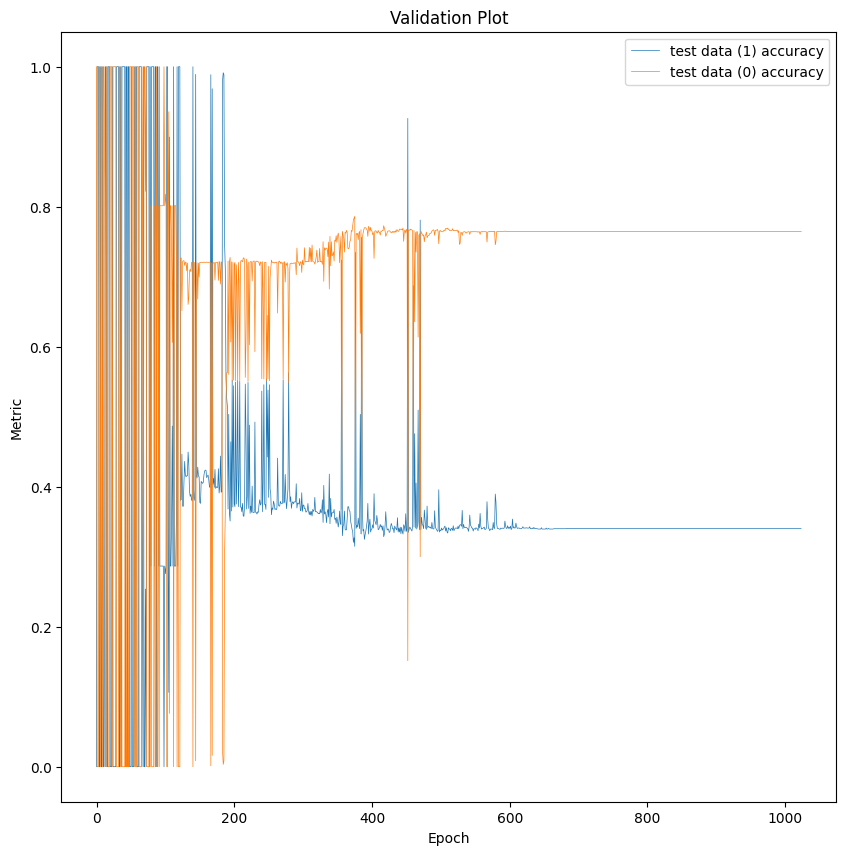

In [5]:
import plot


## load pickle containing weights and history
with open('TRAINED_BIN.pkl', 'rb') as f:
    # load the object from the file
    history, weights = pickle.load(f)

print(history.history.keys())

plot.plot_sets(history.history, ["test data", "test data (1)", "test data (0)"], ["accuracy"], line_width=0.5)


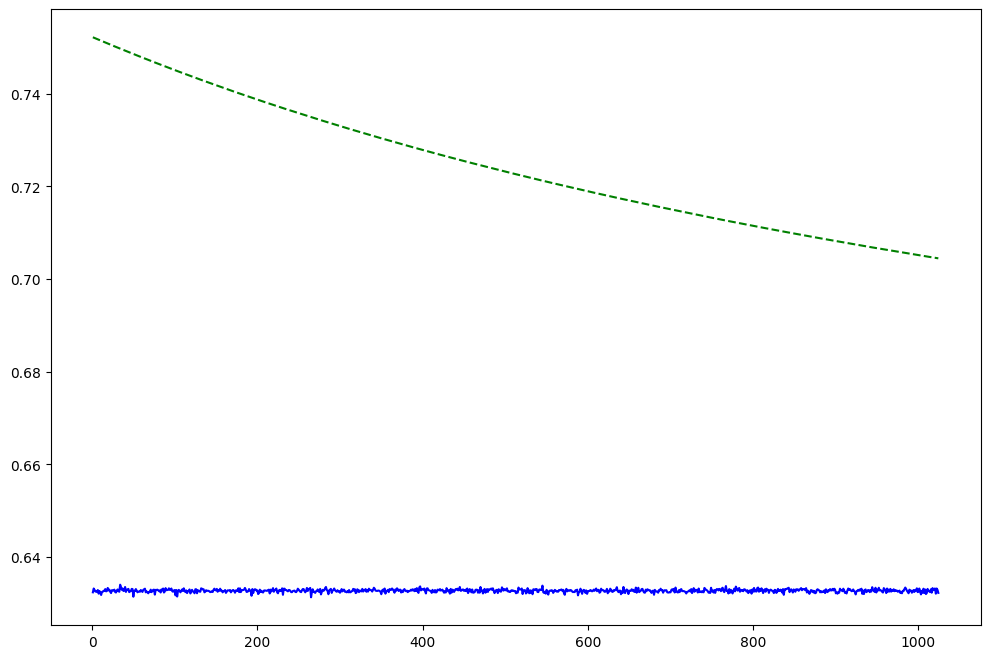

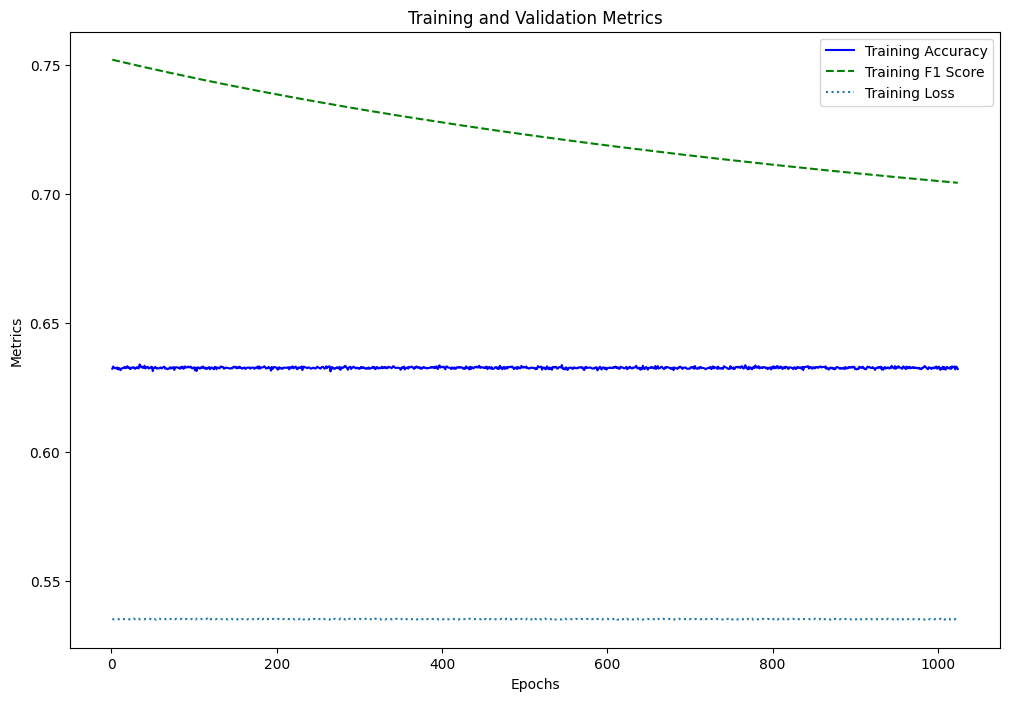

In [22]:
history = supervised_results.history
epochs = range(1, len(history['accuracy']) + 1)
# Create a figure and axis
plt.figure(figsize=(12, 8))
ax = plt.gca()

# Plot training metrics
ax.plot(epochs, history['accuracy'], label='Training Accuracy', linestyle='-', color='b')
ax.plot(epochs, history['f1_score'], label='Training F1 Score', linestyle='--', color='g')
# ax.plot(epochs, history['precision'], label='Training Precision', linestyle='-.', color='r')
# ax.plot(epochs, history['recall'], label='Training Recall', linestyle=':', color='c')

# Plot validation metrics

#ax.plot(epochs, history['val_accuracy'], label='Validation Accuracy', linestyle='-', color='b', alpha=0.5)
#ax.plot(epochs, history['val_f1_score'], label='Validation F1 Score', linestyle='--', color='g', alpha=0.5)
# ax.plot(epochs, history['val_precision'], label='Validation Precision', linestyle='-.', color='r', alpha=0.5)
# ax.plot(epochs, history['val_recall'], label='Validation Recall', linestyle=':', color='c', alpha=0.5)

ax.plot(epochs, history['loss'], label='Training Loss', linestyle=':')

# Set labels and title
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training and Validation Metrics')

# Show legend and plot
plt.legend(loc='best')
plt.show()

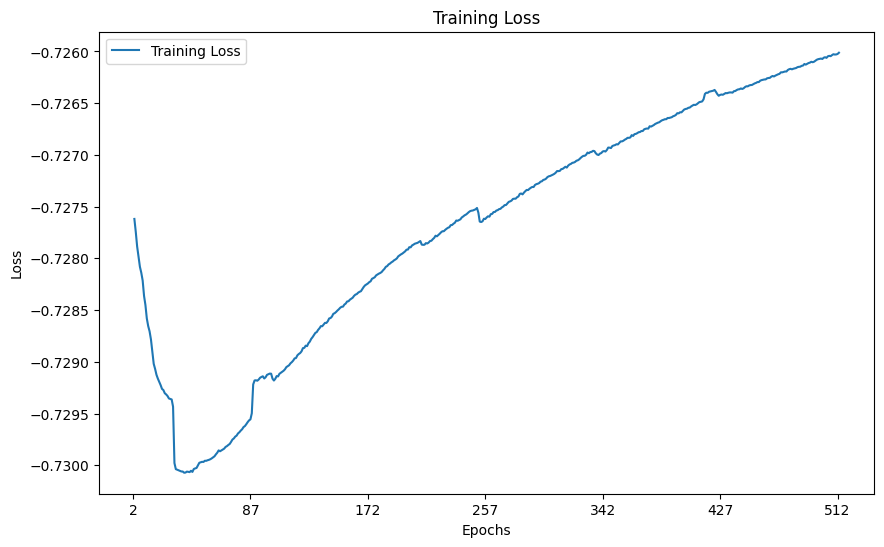

In [12]:
#history = unsupervised_data.history
history = cached_history
epochs = range(1, len(history['loss']) + 1)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.xticks([i for i in range(len(epochs)) if (i % (len(epochs) // 6)) == 0], [i + NUM_EPOCHS_PER_SEARCH for i in range(len(epochs)) if (i % (len(epochs) // 6)) == 0])
plt.show()